# Chain 

## Review

we build a simple graph with nodes, normal edges, and conditional edges

## Goals 

Now let's build up to a single chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools)
* [Executting tool call](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various messages types, inlcuding `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to insruct the behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by a model provider for `AIMessages`) 





In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about?"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================

Great, what would you like to learn about?
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [2]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Model'),
 HumanMessage(content="Yes, that's right.", additional_kwargs={}, response_metadata={}, name='Lance'),
 AIMessage(content='Great, what would you like to learn about?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I want to learn about the best place to see Orcas in the US.', additional_kwargs={}, response_metadata={}, name='Lance')]

## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message
types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI

Let's check that your `HuggingFace` is set and, if not, you will be asked to enter it.

In [3]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key:  ········


In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [5]:
result = llm.invoke(messages)

In [6]:
print(result)

content='The best place to see orcas in the US depends on the time of year.  There are three main regions known for orca sightings:\n\n* **Pacific Northwest (Washington, Oregon, and British Columbia, Canada):** This is generally considered the *best* place to see orcas in the US, particularly the **Salish Sea**, which includes the Puget Sound and surrounding waters.  The best time to see resident orcas here is from **May through September**.  These orcas primarily feed on salmon.\n\n* **Alaska:**  Alaska offers opportunities to see transient orcas, which feed on marine mammals.  The best time to see orcas in Alaska is during the **summer months**, particularly in areas like **Southeast Alaska** and **Prince William Sound**.\n\n* **California:** Orcas can be seen off the coast of California, particularly **Monterey Bay** and the **Channel Islands**, but sightings are less predictable than in the Pacific Northwest or Alaska.  The best time to see them here is typically during the **sprin

In [7]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g. APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will call to choose a tool based upon the natural language input from the user.

And, it will return an output that adhere's to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in langchain is simple.

You can simply pass any Python `function` `ChatModel.bind_tools(function)`

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of toolcalling!

The `multiply` function is our tool.

In [8]:
def multiply(a:int, b:int) -> int:
    """Multiply a and b 

    Args:
        a: first int
        b: second int

    """

    return a * b 

llm_with_tools = llm.bind_tools([multiply])

If we pass an input e.g., `"What is 2 multiplied by 3"` - we see a tool called returned

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2, "b":3}', 'name': 'multiply'}

```



In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3?", name="Ali")])
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5d2400ca-5d87-4612-af93-b4e3c2e0ee7a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '8c22377c-8fa0-4ed5-96c0-714c6079aa21', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 3, 'total_tokens': 61, 'input_token_details': {'cache_read': 0}})

In [13]:
tool_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}

## Using messages as a state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessageState`, as a `TypeDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [14]:
from typing_extensions import TypedDict 
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to our `messages` state key

We can use [render functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updaters are performed.

If no reducer function is specified, then it is assumed that updates to the key should **override** it as we saw before.

But, to append, messages, we can use pre-built `add-messages` reducers.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add messages` reducer function as metadata.


In [17]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built `MessagesState`!

`MessagesState` is defined:

* With a pre-built single `messages` key.
* This is a list of `AnyMessage` objects.
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose then defining a custom `TypedDict`, as shown above.

In [18]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

To go bit deeper, we can see how the `add_messages` reducer works in isolation.

In [19]:
# initial state
initial_messages = [AIMessage(content="Hello, How can I assist you?", name="Model"),
                   HumanMessage(content="I'm looking for information on marine biology.", name="Ali")]

# New message to add

new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages, new_message)


[AIMessage(content='Hello, How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='f02f8b5a-015c-47bd-b950-04dc78a84eb7'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Ali', id='0b75a38e-58f3-4efe-b3d3-59426ff76fd7'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='896fc5f2-5fd0-45d4-a255-bdb9c0eef909')]

## Our graph

Now, let's use `MessagesState` with a graph.

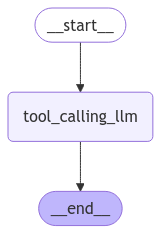

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END 

# Node 
def tool_calling_llm(state: MessageState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass `Hello` the llm responds without any tools call

In [22]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages["messages"]:
    m.pretty_print()
    

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello there! How can I help you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by the tool. 

In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (84151bdb-385d-47a9-8e20-b6ff62a242c3)
 Call ID: 84151bdb-385d-47a9-8e20-b6ff62a242c3
  Args:
    a: 2.0
    b: 3.0
